In [ ]:
# ===== CELL 1: Imports, device, seeds =====

import os
import random
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

# reproducibility
SEED = 777
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print("Using device:", device)


Using device: cuda


C:\Users\user\anaconda3\envs\hw5vit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ===== CELL 2: Tokenization, vocab, encoding =====

import re

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"


def tokenize(text):
    text = str(text).lower()
    tokens = re.findall(r"\w+|\S", text)
    return tokens


def build_vocab(texts, vocab_size=10000, min_freq=1):
    freq = Counter()
    for t in texts:
        freq.update(tokenize(t))

    itos = [PAD_TOKEN, UNK_TOKEN]
    for token, count in freq.most_common():
        if count < min_freq:
            continue
        if len(itos) >= vocab_size:
            break
        itos.append(token)

    stoi = {tok: idx for idx, tok in enumerate(itos)}
    return stoi, itos


def encode(text, stoi, max_len):
    tokens = tokenize(text)
    ids = [stoi.get(tok, stoi[UNK_TOKEN]) for tok in tokens]

    if len(ids) < max_len:
        ids = ids + [stoi[PAD_TOKEN]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]

    return ids


In [ ]:
# ===== CELL 3: Dataset + create_dataloaders =====


class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, stoi, max_len):
        self.texts = texts
        self.labels = labels
        self.stoi = stoi
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x_ids = encode(self.texts[idx], self.stoi, self.max_len)
        y = self.labels[idx]
        return torch.tensor(x_ids, dtype=torch.long), torch.tensor(y, dtype=torch.long)


def create_dataloaders(
    texts,
    labels,
    batch_size=64,
    vocab_size=10000,
    max_len=None,
    test_size=0.15,
    val_size=0.15,
):
   
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        texts,
        labels,
        test_size=test_size,
        random_state=SEED,
        stratify=labels,
    )

    rel_val_size = val_size / (1.0 - test_size)  
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval,
        y_trainval,
        test_size=rel_val_size,
        random_state=SEED,
        stratify=y_trainval,
    )

    stoi, itos = build_vocab(X_train, vocab_size=vocab_size)

    if max_len is None:
        lengths = [len(tokenize(t)) for t in X_train]
        max_len = int(np.percentile(lengths, 95))
    used_max_len = max_len

    print(f"[INFO] Vocab size: {len(itos)}, MAX_LEN: {used_max_len}")

    train_ds = HateSpeechDataset(X_train, y_train, stoi, used_max_len)
    val_ds = HateSpeechDataset(X_val, y_val, stoi, used_max_len)
    test_ds = HateSpeechDataset(X_test, y_test, stoi, used_max_len)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=0
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, num_workers=0
    )

    return stoi, itos, used_max_len, (train_loader, val_loader, test_loader)


In [ ]:
# ===== CELL 4: TextCNN model =====


class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_classes,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        pad_idx=0,
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=embed_dim,
                    out_channels=num_filters,
                    kernel_size=fs,
                )
                for fs in filter_sizes
            ]
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        
        embedded = self.embedding(x)  
        embedded = embedded.permute(0, 2, 1)  

        conv_outs = []
        for conv in self.convs:
            c = conv(embedded)          
            c = torch.relu(c)
            c = torch.max(c, dim=2).values  
            conv_outs.append(c)

        h = torch.cat(conv_outs, dim=1)  
        h = self.dropout(h)
        logits = self.fc(h)              
        return logits


In [5]:
# ===== CELL 5: Training & evaluation utilities =====


def run_epoch(
    model,
    data_loader,
    criterion,
    device,
    optimizer=None,
):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    all_preds = []
    all_labels = []

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * X.size(0)

        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_examples += X.size(0)

        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(y.detach().cpu().tolist())

    avg_loss = total_loss / total_examples
    acc = total_correct / total_examples
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return avg_loss, acc, f1


def train_model(
    model,
    train_loader,
    val_loader,
    device,
    n_epochs=20,
    lr=1e-3,
    class_weights=None,
    patience=5,
):
    model = model.to(device)

    if class_weights is not None:
        cw = torch.tensor(class_weights, dtype=torch.float32, device=device)
        criterion = nn.CrossEntropyLoss(weight=cw)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_f1 = 0.0
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        print(f"\n===== Epoch {epoch}/{n_epochs} =====")

        train_loss, train_acc, train_f1 = run_epoch(
            model, train_loader, criterion, device, optimizer=optimizer
        )
        val_loss, val_acc, val_f1 = run_epoch(
            model, val_loader, criterion, device, optimizer=None
        )

        print(
            f"[LOG] Epoch {epoch:02d} | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f} | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}"
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
            print(f"[INFO] New best model saved (val F1 = {best_val_f1:.4f})")
        else:
            epochs_no_improve += 1
            print(f"[INFO] No improvement for {epochs_no_improve} epoch(s)")
            if epochs_no_improve >= patience:
                print("[INFO] Early stopping triggered.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"[INFO] Loaded best model with val F1 = {best_val_f1:.4f}")

    return model, {
        "best_val_f1": best_val_f1,
    }


def evaluate_model(model, test_loader, device, id2label=None):
    model = model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            total_loss += loss.item() * X.size(0)

            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_examples += X.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    avg_loss = total_loss / total_examples
    acc = total_correct / total_examples
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    print("\n===== TEST RESULTS =====")
    print(f"Test loss: {avg_loss:.4f}")
    print(f"Test acc : {acc:.4f}")
    print(f"Test F1  : {f1:.4f} (macro)")

    if id2label is not None:
        target_names = [id2label[i] for i in sorted(id2label.keys())]
        print("\nClassification report:")
        print(
            classification_report(
                all_labels,
                all_preds,
                target_names=target_names,
                zero_division=0,
            )
        )
    else:
        print("\nClassification report:")
        print(
            classification_report(
                all_labels,
                all_preds,
                zero_division=0,
            )
        )

    print("Confusion matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return avg_loss, acc, f1


In [ ]:
# ===== CELL 6: Load mega_merged_text_label_dataset.csv, train & evaluate =====

DATA_PATH = "mega_merged_text_label_dataset.csv"  

df = pd.read_csv(DATA_PATH)
print("[INFO] Raw columns:", list(df.columns))


TEXT_COL = "text"
LABEL_COL = "label"

df = df[[TEXT_COL, LABEL_COL]].dropna(subset=[TEXT_COL, LABEL_COL])


df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()


label2id = {
    "NORMAL": 0,
    "OFFENSIVE": 1,
    "HATE_SPEECH": 2,
}
id2label = {v: k for k, v in label2id.items()}


df = df[df[LABEL_COL].isin(label2id.keys())]

print("[INFO] Label distribution after filtering:")
print(df[LABEL_COL].value_counts())


texts = df[TEXT_COL].astype(str).tolist()
labels = df[LABEL_COL].map(label2id).astype(int).tolist()

print(f"[INFO] Final dataset size: {len(texts)}")


stoi, itos, max_len, (train_loader, val_loader, test_loader) = create_dataloaders(
    texts,
    labels,
    batch_size=64,
    vocab_size=10000,
    max_len=50,      
    test_size=0.15,
    val_size=0.15,
)


class_counts = Counter(labels)
print("[INFO] Raw class counts:", class_counts)

NUM_CLASSES = 3
total = len(labels)

class_weights = []
for cid in range(NUM_CLASSES):
    count = class_counts.get(cid, 1)
    w = total / (NUM_CLASSES * count)
    class_weights.append(w)

print("[INFO] Final class weights:", class_weights)


EMBED_DIM = 200
FILTER_SIZES = (2, 3, 4, 5)
NUM_FILTERS = 128
DROPOUT = 0.7

model = TextCNN(
    vocab_size=len(itos),
    embed_dim=EMBED_DIM,
    num_classes=NUM_CLASSES,
    filter_sizes=FILTER_SIZES,
    num_filters=NUM_FILTERS,
    dropout=DROPOUT,
    pad_idx=stoi[PAD_TOKEN],
)

print(model)


model, history = train_model(
    model,
    train_loader,
    val_loader,
    device=device,
    n_epochs=25,
    lr=5e-4,            
    class_weights=class_weights,
    patience=5,
)


test_loss, test_acc, test_f1 = evaluate_model(
    model,
    test_loader,
    device=device,
    id2label=id2label,
)

print(f"\n[SUMMARY] Test accuracy: {test_acc:.4f}, Test macro F1: {test_f1:.4f}")


[INFO] Raw columns: ['text', 'label']
[INFO] Label distribution after filtering:
label
NORMAL         1856
OFFENSIVE      1364
HATE_SPEECH     560
Name: count, dtype: int64
[INFO] Final dataset size: 3780
[INFO] Vocab size: 10000, MAX_LEN: 50
[INFO] Raw class counts: Counter({0: 1856, 1: 1364, 2: 560})
[INFO] Final class weights: [0.6788793103448276, 0.9237536656891495, 2.25]
TextCNN(
  (embedding): Embedding(10000, 200, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(200, 128, kernel_size=(2,), stride=(1,))
    (1): Conv1d(200, 128, kernel_size=(3,), stride=(1,))
    (2): Conv1d(200, 128, kernel_size=(4,), stride=(1,))
    (3): Conv1d(200, 128, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

===== Epoch 1/25 =====
[LOG] Epoch 01 | Train loss: 1.1913, acc: 0.4036, f1: 0.3887 | Val loss: 0.9397, acc: 0.5591, f1: 0.5370
[INFO] New best model saved (val F1 = 0.5370)

===== Epoch 2/25 =====
[L

In [ ]:
# ===== CELL 7: Predict for a single comment =====

import torch.nn.functional as F


def predict_comment(text, model, stoi, max_len, id2label, device=device):
    model.eval()
    with torch.no_grad():
        x_ids = encode(text, stoi, max_len)
        x_tensor = torch.tensor([x_ids], dtype=torch.long, device=device)
        logits = model(x_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_id = int(np.argmax(probs))
        pred_label = id2label[pred_id]
    return pred_label, probs

example_text = "честно говоря звучит как хуйня"
pred_label, probs = predict_comment(
    example_text, model, stoi, max_len, id2label, device
)
print("Text:", example_text)
print("Predicted label:", pred_label)
print("Probs:", probs)


Text: честно говоря звучит как хуйня
Predicted label: OFFENSIVE
Probs: [0.15928538 0.7673716  0.07334299]


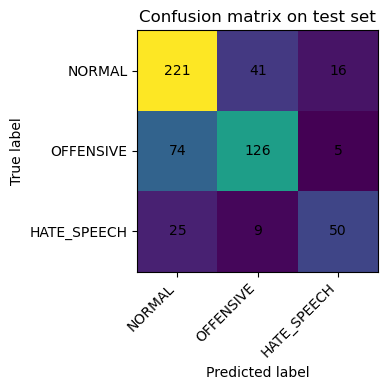

In [ ]:
# ===== CELL 8: Confusion matrix visualization =====

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

classes = [id2label[i] for i in sorted(id2label.keys())]

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
        )

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix on test set")
fig.tight_layout()
plt.show()
